In [1]:
import torch
import torchaudio
import torchaudio.transforms as transforms 
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import glob
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import spectrogram
from scipy.fftpack import dst, dct

songs = '/home/george-vengrovski/Documents/canary_song_detector/sample_songs'
not_songs = '/home/george-vengrovski/Documents/canary_song_detector/sample_not_songs'

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Helper Functions

In [2]:
import os
import shutil
import glob

def train_test_split(train_split=0.8):
    # Create directories if not already created
    if not os.path.exists('test'):
        os.makedirs('test')

    if not os.path.exists('train'):
        os.makedirs('train')

    # Get a list of all song files and non-song files
    songs = glob.glob('/home/george-vengrovski/Documents/canary_song_detector/sample_songs/*.wav')
    not_songs = glob.glob('/home/george-vengrovski/Documents/canary_song_detector/sample_not_songs/*.wav')

    # Split songs into train and test sets
    train_songs = songs[:int(len(songs) * train_split)]
    test_songs = songs[int(len(songs) * train_split):]

    # Copy song files into train and test directories with updated filenames
    for song in train_songs:
        file_name = os.path.basename(song)
        new_file_name = os.path.splitext(file_name)[0] + '_song.wav'
        shutil.copy(song, os.path.join('train', new_file_name))

    for song in test_songs:
        file_name = os.path.basename(song)
        new_file_name = os.path.splitext(file_name)[0] + '_song.wav'
        shutil.copy(song, os.path.join('test', new_file_name))

    # Split non-song files into train and test sets
    train_not_songs = not_songs[:int(len(not_songs) * train_split)]
    test_not_songs = not_songs[int(len(not_songs) * train_split):]

    # Copy non-song files into train and test directories with updated filenames
    for not_song in train_not_songs:
        file_name = os.path.basename(not_song)
        new_file_name = os.path.splitext(file_name)[0] + '_not_song.wav'
        shutil.copy(not_song, os.path.join('train', new_file_name))

    for not_song in test_not_songs:
        file_name = os.path.basename(not_song)
        new_file_name = os.path.splitext(file_name)[0] + '_not_song.wav'
        shutil.copy(not_song, os.path.join('test', new_file_name))
        
train_test_split()

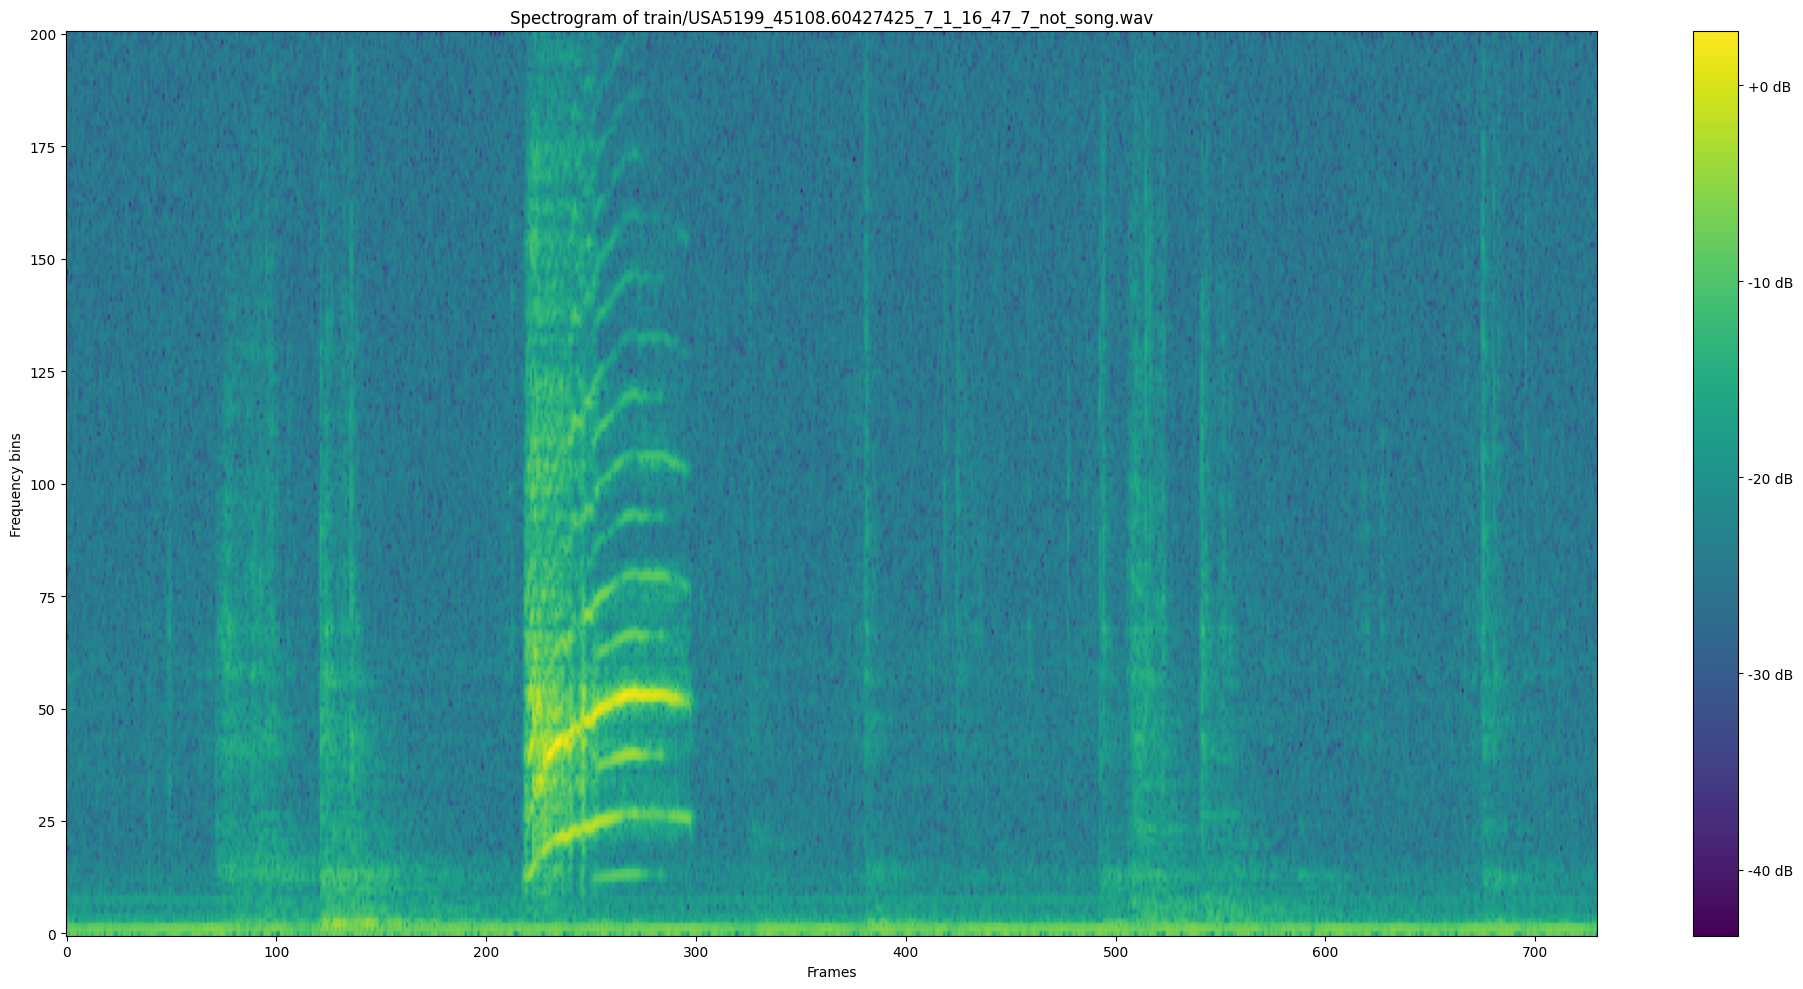

In [3]:
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import torchaudio.transforms as T
import random

class DataSet(Dataset):
    def __init__(self, type):
        song_files = []
        not_song_files = []

        folder = 'train' if type == 'train' else 'test' 

        for file in glob.glob(folder + '/*.wav'):
            if 'not_song' in file:
                not_song_files.append(file)
            else:
                song_files.append(file)

        # Combine all the files without sampling
        self.file_paths = song_files + not_song_files
        self.labels = [1]*len(song_files) + [0]*len(not_song_files)

        # Shuffle file_paths and labels together
        combined = list(zip(self.file_paths, self.labels))
        random.shuffle(combined)
        self.file_paths, self.labels = zip(*combined)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        label = self.labels[index]

        waveform, sample_rate = torchaudio.load(file_path)
        mean = waveform.mean()
        std = waveform.std()
        waveform = (waveform - mean) / std

        label = torch.tensor(label, dtype=torch.float32)  # labels are converted to a float tensor here

        return waveform, label

    def __len__(self):
        return len(self.file_paths)


    def collate_fn(self, batch):
        waveforms, labels = zip(*batch)

        # Pad the waveforms
        waveforms = pad_sequence([torch.flatten(w) for w in waveforms], batch_first=True)

        labels = torch.tensor(labels, dtype=torch.float32)  # labels should be a tensor, not a tuple
        
        return waveforms, labels

    
    def visualize_spectrogram(self, index):
        file_path = self.file_paths[index]
        waveform, sample_rate = torchaudio.load(file_path)

        # Create a spectrogram from the waveform
        spectrogram_transform = T.Spectrogram()
        spectrogram = spectrogram_transform(waveform)

        # Remove the channel dimension
        spectrogram = spectrogram.squeeze(0)

        # Plot the spectrogram
        plt.figure(figsize=(20, 10))
        plt.imshow(spectrogram.log2(), aspect='auto', origin='lower')
        plt.title('Spectrogram of ' + file_path)
        plt.xlabel('Frames')
        plt.ylabel('Frequency bins')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()

    

train_dataset = DataSet(type='train')
train_dataset.visualize_spectrogram(0)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn=train_dataset.collate_fn)

test_dataset = DataSet(type='test')
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=test_dataset.collate_fn)

Classifier Architecture 
- 4 1d conv layers for the waveform of the periodicities, and amplitude 
- LSTM layers afterwards 
- Fully connected layer with two nodes for song v non-song 

In [4]:
class Classifier(nn.Module):
    def __init__(self, feature_extractor_dim, hidden_size, num_layers):
        super(Classifier, self).__init__()

        # Feature extractor
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=feature_extractor_dim, kernel_size=10, padding=1, stride=5)
        self.conv2 = nn.Conv1d(in_channels=feature_extractor_dim, out_channels=feature_extractor_dim, kernel_size=4, padding=1, stride=4)
        self.conv3 = nn.Conv1d(in_channels=feature_extractor_dim, out_channels=feature_extractor_dim, kernel_size=4, padding=1, stride=4)
        self.conv4 = nn.Conv1d(in_channels=feature_extractor_dim, out_channels=feature_extractor_dim, kernel_size=4, padding=1, stride=4)
        self.conv5 = nn.Conv1d(in_channels=feature_extractor_dim, out_channels=feature_extractor_dim, kernel_size=4, padding=1, stride=4)
        self.conv6 = nn.Conv1d(in_channels=feature_extractor_dim, out_channels=feature_extractor_dim, kernel_size=3, padding=1, stride=3)
        self.conv7 = nn.Conv1d(in_channels=feature_extractor_dim, out_channels=feature_extractor_dim, kernel_size=3, padding=1, stride=3)

        # GRU Layer
        self.gru = nn.GRU(input_size=feature_extractor_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)

        # Fully connected layer 
        self.fc1 = nn.Linear(hidden_size*2, 1)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))

        # Reshape for GRU
        x = x.permute(0, 2, 1)

        # x is the output for each timestep of the GRU while h is the final hidden state
        x, h = self.gru(x)

        # squish the 2 directions into 1

        x = h.permute(1, 0, 2)
        x = x.flatten(start_dim=1)

        x = self.fc1(F.relu(x))
        # x = self.fc2(F.relu(x))
        # x = self.fc3(F.relu(x))
        x = torch.sigmoid(x)

        x = x.squeeze(0)
        
        return x 

In [5]:
waveform, labels = next(iter(train_loader))

# # switch first and second dim
# waveform = waveform.transpose(1,2)

waveform = waveform.unsqueeze(1)

model = Classifier(feature_extractor_dim=64, hidden_size=200, num_layers=1)
print(model.forward(waveform).shape)


torch.Size([1])


In [7]:
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt

epochs = 15
learning_rate = 0.0001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Classifier(feature_extractor_dim=16, hidden_size=64, num_layers=1).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_preds = []
    train_labels = []
    for waveform, label in train_loader:
        waveform = waveform.unsqueeze(1).to(device)
        label = label.to(device)  # Changed here
        output = model(waveform)

        # Calculate accuracy
        predicted = (output > 0.5).float()
        train_preds.extend(predicted.detach().cpu().numpy())
        train_labels.extend(label.detach().cpu().numpy())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss = criterion(output, label)
        loss.backward()  # compute the gradients
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracy = balanced_accuracy_score(train_labels, train_preds) * 100
    train_accuracies.append(train_accuracy)
    print ('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%'.format(epoch+1, epochs, train_loss / len(train_loader), train_accuracy))

    # Test the model
    model.eval()
    test_loss = 0.0
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for waveform, label in test_loader:
            waveform = waveform.unsqueeze(1).to(device)
            label = torch.tensor(label, dtype=torch.float32).unsqueeze(1).to(device)
            output = model(waveform)

            # Calculate accuracy
            predicted = (output > 0.5).float()
            test_preds.extend(predicted.cpu().numpy())
            test_labels.extend(label.cpu().numpy())

            # Calculate loss
            loss = criterion(output, label)
            test_loss += loss.item()
        
    test_losses.append(test_loss / len(test_loader))
    test_accuracy = balanced_accuracy_score(test_labels, test_preds) * 100
    test_accuracies.append(test_accuracy)
    print('Epoch [{}/{}], Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(epoch+1, epochs, test_loss / len(test_loader), test_accuracy))

# Plot the training and test losses over time
plt.figure(figsize=(10,5))
plt.title("Training and Test Loss")
plt.plot(train_losses,label="train")
plt.plot(test_losses,label="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the training and test accuracies over time
plt.figure(figsize=(10,5))
plt.title("Training and Test Accuracy")
plt.plot(train_accuracies,label="train")
plt.plot(test_accuracies,label="test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


The model has 41,746 trainable parameters
Epoch [1/15], Train Loss: 0.5434, Train Accuracy: 50.63%


/tmp/ipykernel_8063/1456184657.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).unsqueeze(1).to(device)


Epoch [1/15], Test Loss: 0.4633, Test Accuracy: 50.00%
Epoch [2/15], Train Loss: 0.3546, Train Accuracy: 50.00%


/tmp/ipykernel_8063/1456184657.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).unsqueeze(1).to(device)


Epoch [2/15], Test Loss: 0.3172, Test Accuracy: 50.00%
Epoch [3/15], Train Loss: 0.1982, Train Accuracy: 81.69%


/tmp/ipykernel_8063/1456184657.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).unsqueeze(1).to(device)


Epoch [3/15], Test Loss: 0.2277, Test Accuracy: 94.46%
Epoch [4/15], Train Loss: 0.1118, Train Accuracy: 96.81%


/tmp/ipykernel_8063/1456184657.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).unsqueeze(1).to(device)


Epoch [4/15], Test Loss: 0.2185, Test Accuracy: 94.46%
Epoch [5/15], Train Loss: 0.0879, Train Accuracy: 97.17%


/tmp/ipykernel_8063/1456184657.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).unsqueeze(1).to(device)


Epoch [5/15], Test Loss: 0.1879, Test Accuracy: 94.92%
Epoch [6/15], Train Loss: 0.0749, Train Accuracy: 97.29%


/tmp/ipykernel_8063/1456184657.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).unsqueeze(1).to(device)


Epoch [6/15], Test Loss: 0.1872, Test Accuracy: 94.92%
Epoch [7/15], Train Loss: 0.0685, Train Accuracy: 97.40%


/tmp/ipykernel_8063/1456184657.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).unsqueeze(1).to(device)


Epoch [7/15], Test Loss: 0.1868, Test Accuracy: 94.92%
Epoch [8/15], Train Loss: 0.0641, Train Accuracy: 97.52%


/tmp/ipykernel_8063/1456184657.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).unsqueeze(1).to(device)


Epoch [8/15], Test Loss: 0.1804, Test Accuracy: 94.92%
Epoch [9/15], Train Loss: 0.0597, Train Accuracy: 97.40%


/tmp/ipykernel_8063/1456184657.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).unsqueeze(1).to(device)


Epoch [9/15], Test Loss: 0.1735, Test Accuracy: 94.92%
Epoch [10/15], Train Loss: 0.0550, Train Accuracy: 97.52%


/tmp/ipykernel_8063/1456184657.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).unsqueeze(1).to(device)


Epoch [10/15], Test Loss: 0.1726, Test Accuracy: 94.00%
Epoch [11/15], Train Loss: 0.0519, Train Accuracy: 97.99%


/tmp/ipykernel_8063/1456184657.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).unsqueeze(1).to(device)


Epoch [11/15], Test Loss: 0.2496, Test Accuracy: 91.25%
Epoch [12/15], Train Loss: 0.0536, Train Accuracy: 97.76%


/tmp/ipykernel_8063/1456184657.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).unsqueeze(1).to(device)


Epoch [12/15], Test Loss: 0.1333, Test Accuracy: 95.38%
Epoch [13/15], Train Loss: 0.0547, Train Accuracy: 97.76%


/tmp/ipykernel_8063/1456184657.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).unsqueeze(1).to(device)


Epoch [13/15], Test Loss: 0.1312, Test Accuracy: 95.38%
Epoch [14/15], Train Loss: 0.0513, Train Accuracy: 98.47%


/tmp/ipykernel_8063/1456184657.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).unsqueeze(1).to(device)


Epoch [14/15], Test Loss: 0.1672, Test Accuracy: 94.00%
Epoch [15/15], Train Loss: 0.0481, Train Accuracy: 98.35%


/tmp/ipykernel_8063/1456184657.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).unsqueeze(1).to(device)


Epoch [15/15], Test Loss: 0.1179, Test Accuracy: 95.38%


(tensor(1.),)
tensor([1.0000], device='cuda:0', grad_fn=<SqueezeBackward1>)
